## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [8]:
df

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,1,rent,60,39,married,no,fixed,69,92,0,0,900,1020,1
4450,22,owner,60,46,married,no,fixed,60,75,3000,600,950,1263,0
4451,0,owner,24,37,married,no,partime,60,90,3500,0,500,963,1
4452,0,rent,48,23,single,no,freelance,49,140,0,0,550,550,0


In [9]:
df.dtypes[df.dtypes == 'object'], df.dtypes[df.dtypes != 'object']

(home       object
 marital    object
 records    object
 job        object
 dtype: object,
 seniority    int64
 time         int64
 age          int64
 expenses     int64
 income       int64
 assets       int64
 debt         int64
 amount       int64
 price        int64
 default      int64
 dtype: object)

In [10]:
df['seniority'].nunique()

47

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

In [13]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [14]:
len(y_train), len(y_val), len(y_test)

(2672, 891, 891)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [15]:
categorical = list(df_train.dtypes[df.dtypes == 'object'].index)
numerical = list(df_train.dtypes[df.dtypes != 'object'].index)


In [16]:
categorical, numerical

(['home', 'marital', 'records', 'job'],
 ['seniority',
  'time',
  'age',
  'expenses',
  'income',
  'assets',
  'debt',
  'amount',
  'price'])

In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
t = df_train['seniority'].mean()
predict_positive = (df_train['seniority'] >= t).astype('int')
predict_negative = (df_train['seniority'] < t).astype('int')

predict_positive, predict_negative

(0       1
 1       0
 2       0
 3       0
 4       1
        ..
 2667    0
 2668    0
 2669    1
 2670    0
 2671    0
 Name: seniority, Length: 2672, dtype: int64,
 0       0
 1       1
 2       1
 3       1
 4       0
        ..
 2667    1
 2668    1
 2669    0
 2670    1
 2671    1
 Name: seniority, Length: 2672, dtype: int64)

In [19]:
roc_auc_score(predict_positive, y_train)

0.3867150627914303

In [20]:
t = df_train['time'].mean()
predict_time = (df_train['time'] >= t).astype('int')

roc_auc_score(predict_time, y_train)

0.5392097835172689

In [21]:
t = df_train['income'].mean()
predict_income = (df_train['income'] >= t).astype('int')

roc_auc_score(predict_income, y_train)

0.4117814998096688

In [22]:
t = df_train['debt'].mean()
predict_debt = (df_train['debt'] >= t).astype('int')

roc_auc_score(predict_debt, y_train)

0.4962852112676056

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

#### time

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [23]:
set_col = ['seniority', 'income', 'assets', 'records', 'job', 'home']

dv = DictVectorizer(sparse=False)

train_dict = df_train[set_col].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [24]:
val_dict = df_val[set_col].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
default_decision = (y_pred >= 0.5)
round((y_val == default_decision).mean(), 3)

0.78

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [25]:
import matplotlib.pyplot as plt

In [26]:
np.arange(0, 1, 0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [27]:
thresholds = np.arange(0, 1, 0.01)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    scores.append((t, p, r))
    
    #print(t, p, r)



<ipython-input-27-b38717ed2f38>:18: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


In [28]:
scores

[(0.0, 0.2760942760942761, 1.0),
 (0.01, 0.2792281498297389, 1.0),
 (0.02, 0.2847141190198366, 0.991869918699187),
 (0.03, 0.2898203592814371, 0.983739837398374),
 (0.04, 0.30062111801242236, 0.983739837398374),
 (0.05, 0.30407124681933845, 0.9715447154471545),
 (0.06, 0.31241830065359477, 0.9715447154471545),
 (0.07, 0.3203230148048452, 0.967479674796748),
 (0.08, 0.3296398891966759, 0.967479674796748),
 (0.09, 0.33905579399141633, 0.9634146341463414),
 (0.1, 0.34558823529411764, 0.9552845528455285),
 (0.11, 0.3531202435312024, 0.943089430894309),
 (0.12, 0.3656597774244833, 0.9349593495934959),
 (0.13, 0.37976782752902155, 0.9308943089430894),
 (0.14, 0.38813559322033897, 0.9308943089430894),
 (0.15, 0.40353982300884955, 0.926829268292683),
 (0.16, 0.4106813996316759, 0.9065040650406504),
 (0.17, 0.41825095057034223, 0.8943089430894309),
 (0.18, 0.427734375, 0.8902439024390244),
 (0.19, 0.43887775551102204, 0.8902439024390244),
 (0.2, 0.4460580912863071, 0.8739837398373984),
 (0.21, 

In [29]:
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

In [30]:
df_scores

,threshold,precision,recall
0,0.00,0.276094,1.00000
1,0.01,0.279228,1.00000
2,0.02,0.284714,0.99187
3,0.03,0.289820,0.98374
4,0.04,0.300621,0.98374
...,...,...,...
95,0.95,NaN,0.00000
96,0.96,NaN,0.00000
97,0.97,NaN,0.00000
98,0.98,NaN,0.00000


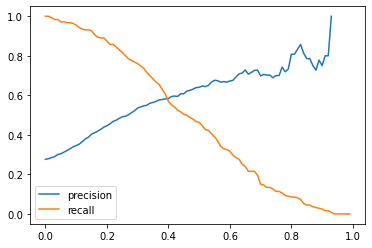

In [31]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

#### 0.4

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [32]:
thresholds = np.arange(0, 1, 0.01)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    f1 = 2 * ((p*r) / (p+r))
    
    scores.append((t, f1))
    
    #print(t, p, r)

<ipython-input-32-2cc736fd053d>:18: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


In [33]:
scores

[(0.0, 0.43271767810026385),
 (0.01, 0.4365572315882875),
 (0.02, 0.442429737080689),
 (0.03, 0.4477335800185014),
 (0.04, 0.46051379638439577),
 (0.05, 0.46317829457364346),
 (0.06, 0.47279920870425324),
 (0.07, 0.4812942366026289),
 (0.08, 0.4917355371900827),
 (0.09, 0.5015873015873017),
 (0.1, 0.5075593952483801),
 (0.11, 0.5138427464008859),
 (0.12, 0.5257142857142857),
 (0.13, 0.5394581861012957),
 (0.14, 0.5478468899521531),
 (0.15, 0.562268803945746),
 (0.16, 0.5652724968314322),
 (0.17, 0.5699481865284974),
 (0.18, 0.5778364116094987),
 (0.19, 0.5879194630872484),
 (0.2, 0.5906593406593407),
 (0.21, 0.5952045133991537),
 (0.22, 0.6054519368723099),
 (0.23, 0.6072992700729927),
 (0.24, 0.6107784431137725),
 (0.25, 0.6137404580152672),
 (0.26, 0.6108527131782946),
 (0.27, 0.6117274167987321),
 (0.28, 0.617124394184168),
 (0.29, 0.6217105263157895),
 (0.3, 0.6285714285714286),
 (0.31, 0.6279863481228668),
 (0.32, 0.6273830155979202),
 (0.33, 0.6219081272084805),
 (0.34, 0.6220614

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

##### 0.3

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [55]:
def train(df_full_train, y_train, C=1.0):
    dicts = df_full_train[set_col].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [56]:
dv, model = train(df_train, y_train, C=1.0)

In [57]:
def predict(df, dv, model):
    dicts = df[set_col].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [58]:
y_pred = predict(df_val, dv, model)

In [38]:
from sklearn.model_selection import KFold

In [39]:
#pip install tqdm

In [40]:
from tqdm.auto import tqdm

In [59]:
n_splits = 5


kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=1)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=10 0.796 +- 0.038


In [54]:
scores

[0.8248391248391249,
 0.8233418747392884,
 0.7828118772419291,
 0.8204319459183274,
 0.7267077219967648]

In [60]:
dv, model = train(df_train, df_train.default.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.6822007217069095

In [49]:
np.std(scores)

0.038171971781451056

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [62]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.795 +- 0.025
C=0.1 0.811 +- 0.016
C=1 0.796 +- 0.038
C=10 0.796 +- 0.038


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

#### 0.1

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.